In [1]:
import pandas as pd
import optimization_utilities as opt_utils

## Retrieve Data

In [2]:
# Import scaled earthquake data
df = pd.read_csv('../Resources/earthquake_data_standardized.csv')
df.head()

,longitude,latitude,depth,magnitude,number_stations,min_station_distance,nodal_plane_1_dip,nodal_plane_1_rake,nodal_plane_1_strike,nodal_plane_2_dip,...,percent_double_couple,scalar_moment,tensor_mpp,tensor_mrp,tensor_mrr,tensor_mrt,tensor_mtp,tensor_mtt,soil_density,mmi_class
0,-0.858789,0.217395,-0.138401,1.259068,-0.162005,-0.621166,0.764993,0.856091,-0.187953,-3.275980,...,-0.131701,-0.058242,-0.053888,-0.019118,-0.003759,-0.020843,-0.042471,0.055255,-1.885829,2
1,-1.586411,1.453026,2.957343,0.278647,-0.799719,0.182939,-0.322804,-1.396320,-0.143028,0.718901,...,-0.016844,-0.065891,-0.050703,-0.004675,-0.031174,-0.034918,-0.064978,0.059791,0.643055,0
2,-0.451425,1.705352,1.297980,0.866900,-0.368324,2.000126,-0.866703,-0.789901,-0.187953,-1.531736,...,-0.045558,-0.062687,-0.048152,0.025176,-0.045815,-0.028006,-0.074322,0.061360,-0.257281,0
3,-0.891745,0.639950,-0.776489,0.808074,-0.405837,-0.566141,-0.594754,-0.010221,0.620696,0.775167,...,-0.138879,-0.063113,-0.047294,-0.015576,-0.037577,-0.028875,-0.058419,0.058169,1.440778,0
4,0.049063,0.917870,-0.567035,0.866900,1.919944,1.537912,-0.594754,-1.396320,1.564120,0.775167,...,-0.009665,-0.062141,-0.048454,0.008477,-0.034790,-0.019123,-0.052158,0.058550,-0.138119,1


## Create X and y

In [3]:
# Define features and target
X = df.drop(columns='mmi_class', axis=1)
y = df['mmi_class']
display(X.head())
display(y[:5])

,longitude,latitude,depth,magnitude,number_stations,min_station_distance,nodal_plane_1_dip,nodal_plane_1_rake,nodal_plane_1_strike,nodal_plane_2_dip,...,t_axis_plunge,percent_double_couple,scalar_moment,tensor_mpp,tensor_mrp,tensor_mrr,tensor_mrt,tensor_mtp,tensor_mtt,soil_density
0,-0.858789,0.217395,-0.138401,1.259068,-0.162005,-0.621166,0.764993,0.856091,-0.187953,-3.275980,...,3.288087,-0.131701,-0.058242,-0.053888,-0.019118,-0.003759,-0.020843,-0.042471,0.055255,-1.885829
1,-1.586411,1.453026,2.957343,0.278647,-0.799719,0.182939,-0.322804,-1.396320,-0.143028,0.718901,...,0.813702,-0.016844,-0.065891,-0.050703,-0.004675,-0.031174,-0.034918,-0.064978,0.059791,0.643055
2,-0.451425,1.705352,1.297980,0.866900,-0.368324,2.000126,-0.866703,-0.789901,-0.187953,-1.531736,...,-0.542928,-0.045558,-0.062687,-0.048152,0.025176,-0.045815,-0.028006,-0.074322,0.061360,-0.257281
3,-0.891745,0.639950,-0.776489,0.808074,-0.405837,-0.566141,-0.594754,-0.010221,0.620696,0.775167,...,-0.274021,-0.138879,-0.063113,-0.047294,-0.015576,-0.037577,-0.028875,-0.058419,0.058169,1.440778
4,0.049063,0.917870,-0.567035,0.866900,1.919944,1.537912,-0.594754,-1.396320,1.564120,0.775167,...,-0.128764,-0.009665,-0.062141,-0.048454,0.008477,-0.034790,-0.019123,-0.052158,0.058550,-0.138119


0    2
1    0
2    0
3    0
4    1
Name: mmi_class, dtype: int64

## Evaluate Base Models
We will evaluate the following five classifiers without optimization.
* Random Forest Classifier - RFC
* K-Nearest-Neighbor Classifier - KNN
* Decision Tree Classifier - DT
* Multinomial Logistic Regression Classifier - Logistic Regression
* Support Vector Machine Classifier - SVM

We will use balanced accuracy scores on the train and test data sets to evaluate the performance of each classifier.  
To mitigate against the variations caused by using different values in the various `random_state` seeds, we will run our algorithm with five different seeds and average the results. 

In [4]:
# Define a list of classifiers to evaluate
classifiers = {'Classifier': ['RFC', 'KNN', 'DT', 'Logistic Regression', 'SVM'],
               'Full Name': ['Random Forest', 'K Nearest Neighbors', 'Decision Tree',
                             'Multinomial Logistic Regression', 'Support Vector Machine'],
               'Mean Train Accuracy': [],
               'Mean Test Accuracy': []}

# Define a list of seeds
seeds = [1, 7, 13, 29, 42]

In [5]:
# Loop over the list of classifiers to evaluate
for classifier in classifiers['Classifier']:

    # Loop over seeds and calculate an average using different seeds
    sum_train_accuracy = 0
    sum_test_accuracy = 0
    for seed in seeds:
        # Evaluate each classifier
        train_accuracy, test_accuracy, test_class_report = \
                                        opt_utils.evaluate_base_model(X, y, classifier, seed)
        
        sum_train_accuracy += train_accuracy
        sum_test_accuracy += test_accuracy
        # print(f"\nClassification Report - Test:\n {test_class_report}")
    classifiers['Mean Train Accuracy'].append(sum_train_accuracy/len(seeds))
    classifiers['Mean Test Accuracy'].append(sum_test_accuracy/len(seeds))
    
df_classifiers = pd.DataFrame(classifiers)
display(df_classifiers)

,Classifier,Full Name,Mean Train Accuracy,Mean Test Accuracy
0,RFC,Random Forest,1.000000,0.629555
1,KNN,K Nearest Neighbors,0.658427,0.476893
2,DT,Decision Tree,1.000000,0.525217
3,Logistic Regression,Multinomial Logistic Regression,0.627698,0.594435
4,SVM,Support Vector Machine,0.737293,0.589214


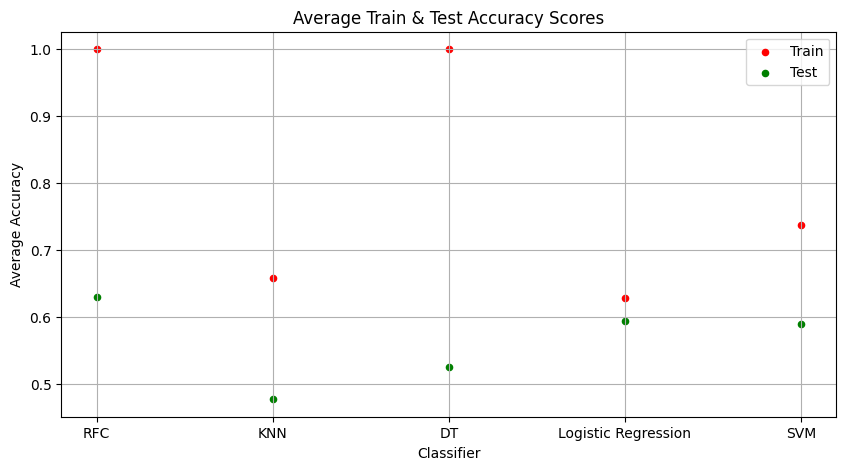

In [6]:
# Plot the results
ax1 = df_classifiers.plot(kind='scatter',
                          x='Classifier',
                          y='Mean Train Accuracy',
                          color='red',
                          label='Train')
ax2 = df_classifiers.plot(kind='scatter',
                          figsize=(10,5),
                          grid=True,
                          title='Average Train & Test Accuracy Scores',
                          x='Classifier',
                          y='Mean Test Accuracy',
                          ylabel='Average Accuracy',
                          color='green',
                          label='Test',
                          ax = ax1)

### Conclusions
1. Without any optimization the Random Forest Classifier model performs the best as measured by the average balanced test accuracy. However, it is overfitting as indicated by an average balanced train accuracy of 1.0.
2. Of the classifiers that are not overfitting, the Multinomial Logistic Regression Classifier performs the best as measured by the balanced test accuracy, followed closely by the Support Vector Machine Classifier.

We will proceed with the **Random Forest Classifier**, the **Multinomial Logistic Regression Classifier** and the **Support Vector Machine Classifier**.

Since the Random Forest Classifier model is overfitting, we will attempt to address that first. One strategy to combat overfitting is to reduce the number of features of the model. We will try two approaches:
1. Use p-values to find the optimal number of features.
2. Use PCA to find the optimal number of components.

## Reduce Feature Set for Random Forest Classifier Model

### P-Values Approach

To see whether removing features improves the overfitting, we remove features one by one in descending order of their p-values. We then determine how many features we have to remove for the balanced accuracy score of the train data set to drop below one.  
Again, to mitigate against the variations caused by using different values in the various `random_state` seeds, we will run our algorithm with five different seeds and average the results.

Seed: 1
Record with first balanced train accuracy score less than one.


,Features Removed,Cutoff,Train Accuracy,Test Accuracy
0,29,3.095053e-28,0.609977,0.477136


Seed: 7
Record with first balanced train accuracy score less than one.


,Features Removed,Cutoff,Train Accuracy,Test Accuracy
0,29,2.121949e-15,0.986669,0.402497


Seed: 13
Record with first balanced train accuracy score less than one.


,Features Removed,Cutoff,Train Accuracy,Test Accuracy
0,29,0.00001,0.617923,0.469949


Seed: 29
Record with first balanced train accuracy score less than one.


,Features Removed,Cutoff,Train Accuracy,Test Accuracy
0,29,0.000082,0.635404,0.445331


Seed: 42
Record with first balanced train accuracy score less than one.


,Features Removed,Cutoff,Train Accuracy,Test Accuracy
0,28,3.113835e-18,0.990089,0.456379
1,29,3.152019e-22,0.624351,0.422634


Average Features Removed: 28.800.
Average Train Accuracy: 0.768.
Average Test Accuracy: 0.450.


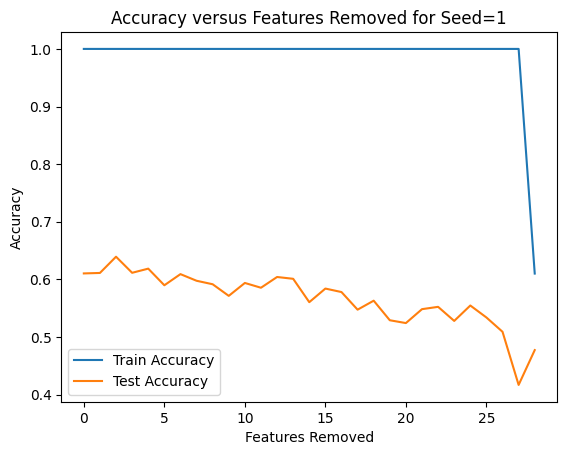

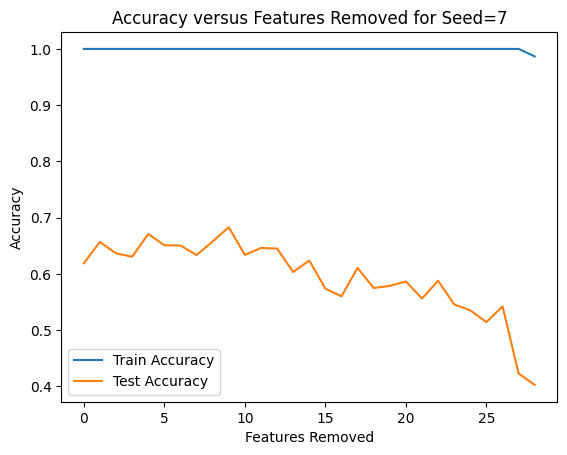

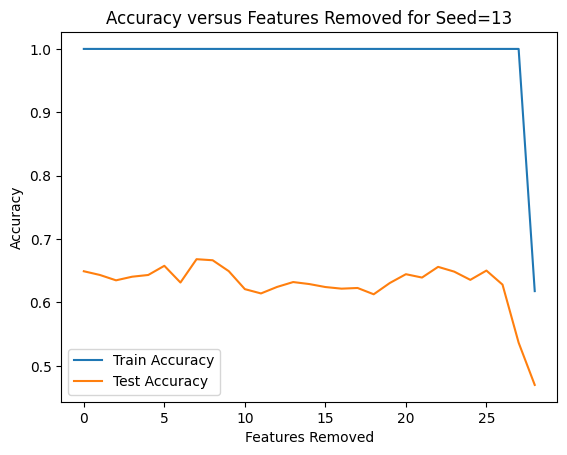

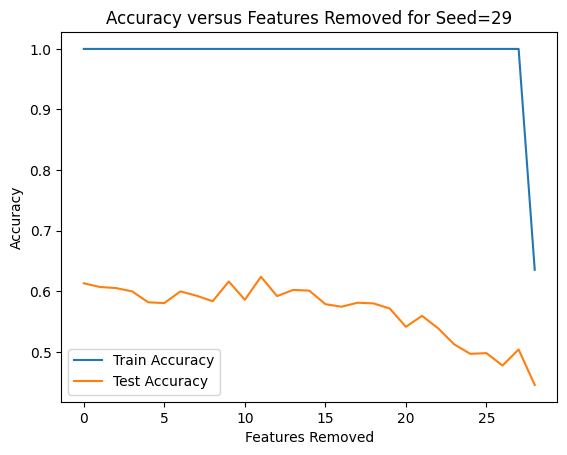

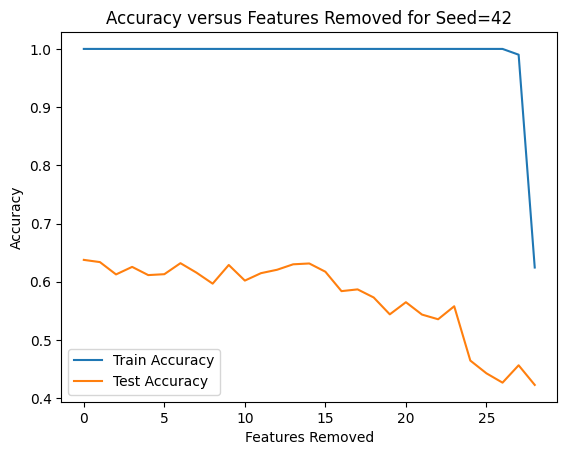

In [7]:
# Loop over seeds and calculate an average using different seeds
sum_features_removed = 0
sum_train_accuracy = 0
sum_test_accuracy = 0
for seed in seeds:
    print(f"Seed: {seed}")
    # Use p-Values to reduce features
    df_reduced_features = opt_utils.pvalues_optimization(X, y, 'RFC', seed)

    # Find the record(s) where the train accuracy is less than one
    best_record = df_reduced_features[df_reduced_features['Train Accuracy']<1.0].reset_index(drop=True)
    print("Record with first balanced train accuracy score less than one.")
    display(best_record)
    sum_features_removed += best_record.at[0, 'Features Removed']
    sum_train_accuracy += best_record.at[0, 'Train Accuracy']
    sum_test_accuracy += best_record.at[0, 'Test Accuracy']

    # Plot accuracies versus number of features removed
    plot_title = f"Accuracy versus Features Removed for Seed={seed}"
    df_reduced_features.drop(columns=['Features Removed',
                                      'Cutoff']).plot(title=plot_title,
                                                      xlabel='Features Removed',
                                                      ylabel='Accuracy')
    
print(f"Average Features Removed: {sum_features_removed/len(seeds):.3f}.")
print(f"Average Train Accuracy: {sum_train_accuracy/len(seeds):.3f}.")
print(f"Average Test Accuracy: {sum_test_accuracy/len(seeds):.3f}.")

### Conclusion
For the balanced accuracy score of the train data to drop below 1.0 we need to remove 29 of 31 features. At that point the balanced test accuracy score drops well below 0.5. Therefore, using p-values to reduce the overfitting of the Random Forest Classifier model is not a viable approach. 

### PCA Approach

We vary the number of PCA components from 2 to the number of features minus one to see whether there is a number of components at which the balanced train accuracy drops below 1.0.  
To mitigate against the variations caused by using different values in the various `random_state` seeds, we will run our algorithm with five different seeds.

Seed: 1


,Explained Variance,Train Accuracy,Test Accuracy
Components,,,


Seed: 7


,Explained Variance,Train Accuracy,Test Accuracy
Components,,,


Seed: 13


,Explained Variance,Train Accuracy,Test Accuracy
Components,,,


Seed: 29


,Explained Variance,Train Accuracy,Test Accuracy
Components,,,


Seed: 42


,Explained Variance,Train Accuracy,Test Accuracy
Components,,,


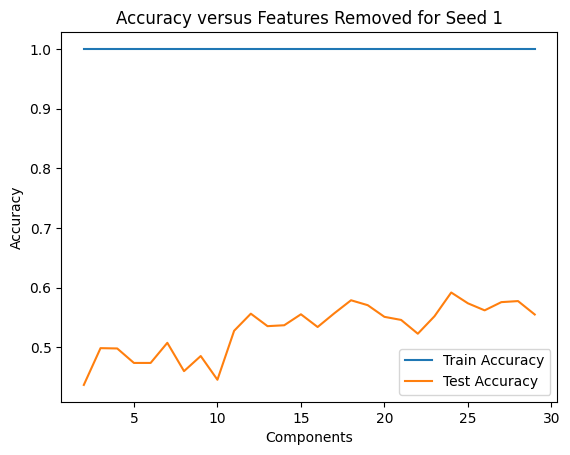

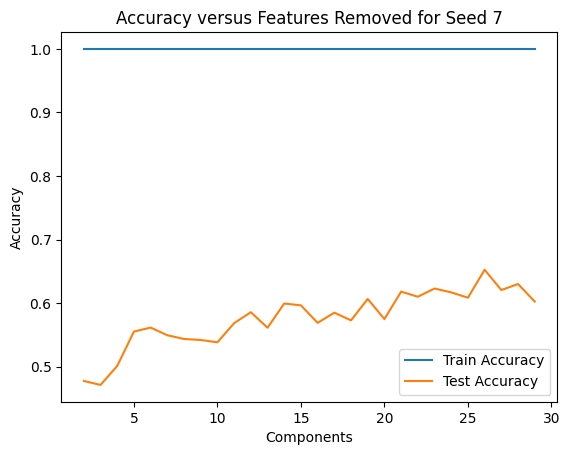

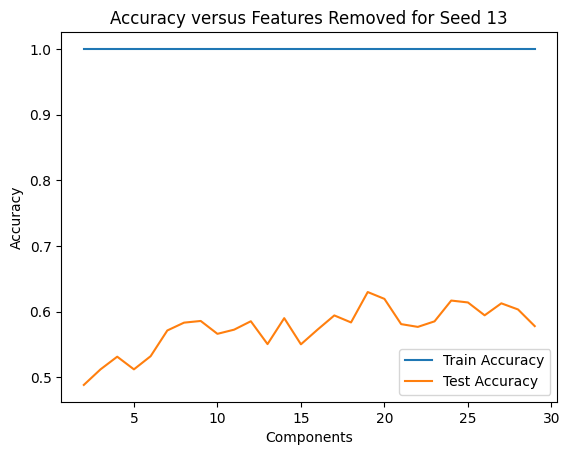

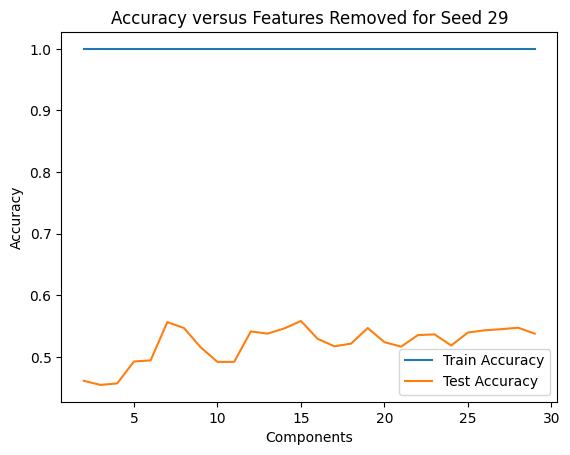

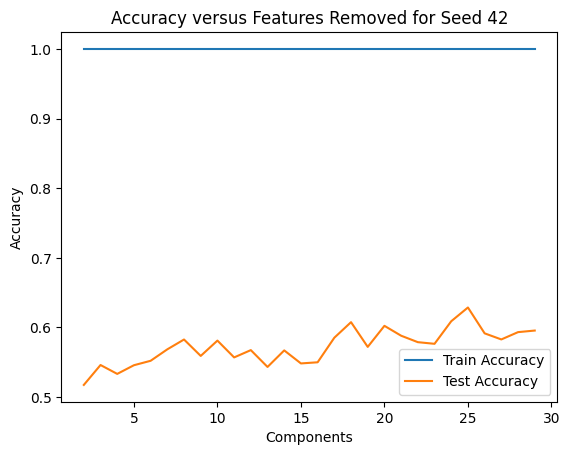

In [8]:
# Loop over seeds
for seed in seeds:
    print(f"Seed: {seed}")
    # Generate a dataframe that contains the 'Explained Variance', the 'Train Accuracy', and the
    # 'Test Accuracy' when the number of components varies from 2 to the number of features
    # minus one.
    df_reduced_features = opt_utils.pca_optimization(X, y, 'RFC', seed)

    # Find the record(s) where the train accuracy is less than one
    best_record = df_reduced_features[df_reduced_features['Train Accuracy']<1.0]
    display(best_record)

    # Plot accuracies versus number of features removed
    plot_title = f"Accuracy versus Features Removed for Seed {seed}"
    df_reduced_features.drop(columns='Explained Variance').plot(title=plot_title,
                                                                ylabel='Accuracy')

### Conclusion
Regardless of how many components we choose in the PCA approach, the balanced accuracy score for the train data set never deviates from 1.0. Therefore, PCA is not a viable approach to address the overfitting of the Random Forest Classifier model.

We will now turn to hyperparameter tuning to see whether we can improve the performance of our models.

## Hyperparameter Tuning

We will perform hyperparameter tuning on the following three classifiers:
* Random Forest Classifier,
* Multinomial Logistic Regression Classifier, and
* Support Vector Machine Classifier.

We pick those because they performed the best when we applied them to our data without optimization.

### Tuning the Random Forest Classifier

#### Maximum Depth Tuning

Seed: 1


,Train Accuracy,Test Accuracy,Difference
Depth,,,
5,0.788734,0.632300,0.156434
6,0.844273,0.611604,0.232669
7,0.889253,0.611875,0.277378
8,0.939887,0.626925,0.312962
9,0.973721,0.623795,0.349925
10,0.988871,0.611604,0.377266
11,0.997465,0.616851,0.380614
12,1.000000,0.616846,0.383154


Seed: 7


,Train Accuracy,Test Accuracy,Difference
Depth,,,
6,0.806891,0.623323,0.183568
7,0.866134,0.626804,0.239330
8,0.927664,0.633636,0.294028
9,0.970903,0.653181,0.317721
10,0.983080,0.647541,0.335539
11,0.992203,0.652413,0.339789
12,0.993976,0.654038,0.339938
13,1.000000,0.667182,0.332818


Seed: 13


,Train Accuracy,Test Accuracy,Difference
Depth,,,
3,0.635622,0.616838,0.018784
4,0.718890,0.646537,0.072353
5,0.780691,0.660265,0.120427
6,0.839648,0.655298,0.184351
7,0.899023,0.654976,0.244047
8,0.943470,0.669934,0.273536
9,0.974697,0.651826,0.322871
10,0.990837,0.648353,0.342484
11,0.996996,0.668705,0.328292


Seed: 29


,Train Accuracy,Test Accuracy,Difference
Depth,,,
7,0.887317,0.610622,0.276696
11,0.996357,0.614260,0.382097
12,1.000000,0.610056,0.389944


Seed: 42


,Train Accuracy,Test Accuracy,Difference
Depth,,,
6,0.806992,0.608499,0.198493
7,0.895467,0.631329,0.264138
8,0.939095,0.625675,0.313420
9,0.973522,0.635946,0.337576
10,0.991268,0.626588,0.364680
11,0.993812,0.625461,0.368352
12,0.995634,0.637091,0.358543
13,0.995634,0.619610,0.376024
14,1.000000,0.639649,0.360351


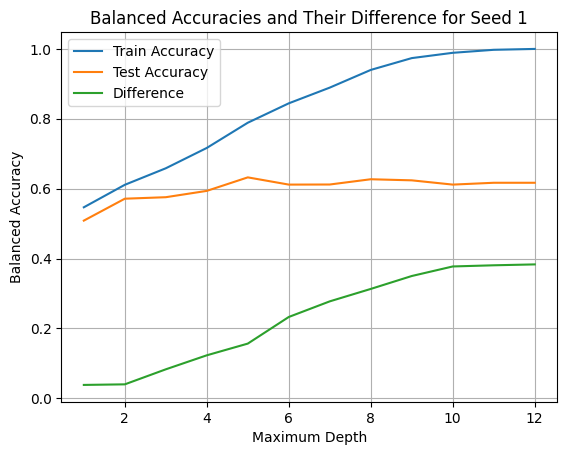

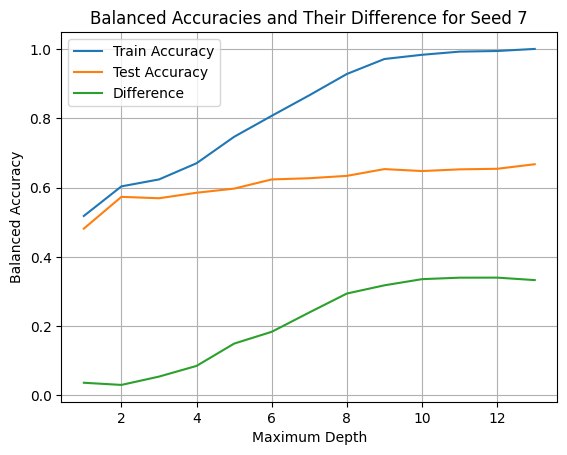

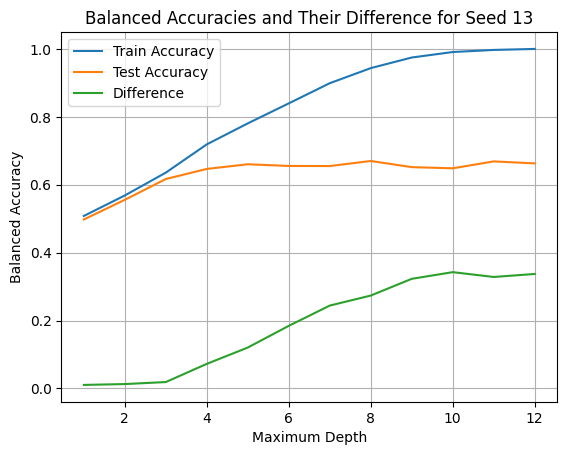

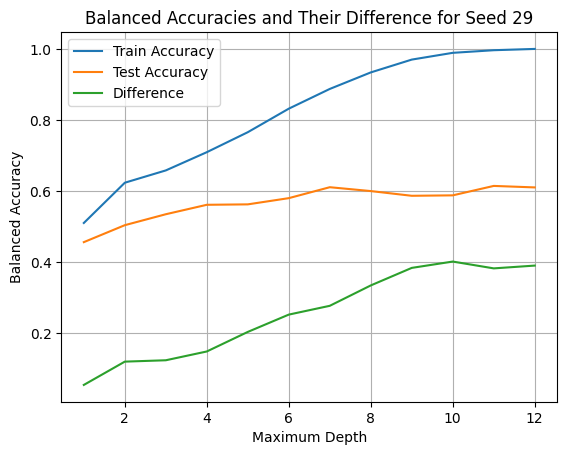

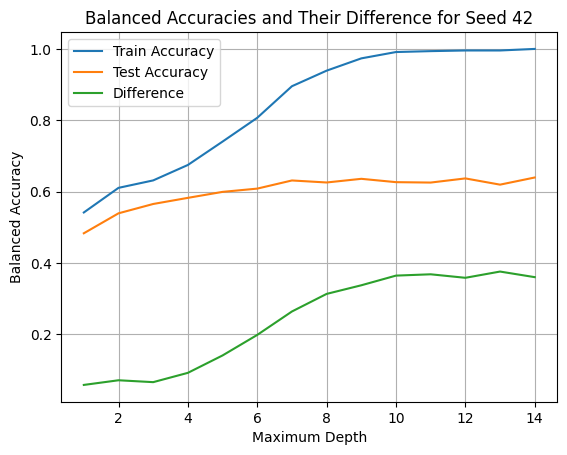

In [11]:
# Loop over seeds
for seed in seeds:   
    print(f"Seed: {seed}")
    # Perform max_depth parameter tuning
    df_rfc_scores = opt_utils.rfc_max_depth_tuning(X, y, seed)

    # Display accuracy scores where 'Test Accuracy' is at least 0.6
    display(df_rfc_scores[df_rfc_scores['Test Accuracy']>=0.6])

    # Plot train and test accuracies and their difference versus max_depth
    df_rfc_scores.plot(title=f"Balanced Accuracies and Their Difference for Seed {seed}",
                       xlabel='Maximum Depth',
                       ylabel='Balanced Accuracy',
                       grid=True)

#### Conclusion
By tuning the `max_depth` parameter of the Random Forest Classifier model we can substantially reduce the overfitting of the model.  

To determine the effect of the other hyperparameters on our Random Forest Classifier model we will choose a value of `max_depth=6`. It mostly results in a balanced test accuracy of above 0.6 with a balanced train accuracy of about 0.8.  

#### Other Hyperparameter Tuning
With `max_depth=6`, we will now vary the following additional hyperparameters.
* n_estimators,
* max_features,
* min_samples_split,
* min_samples_leaf,
* bootstrap.

We use a randomized search estimator to explore the hyperparameter space and find the optimal set of values.

In [10]:
# Define a hyperparameter grid
rfc_param_grid = {'n_estimators': range(100, 1000, 10),
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [6],
                  'min_samples_split': [2, 3, 4, 5],
                  'min_samples_leaf': [1, 2, 4],
                  'bootstrap': [True, False]}

In [11]:
# Initialize sums used to calculate averages
sum_train_accuracy = 0
sum_test_accuracy = 0

# Loop over seeds
for seed in seeds:

    # Find best fit parameters and corresponding train and test accuracies
    best_params, train_accuracy, test_accuracy = opt_utils.full_hp_tuning(X, y, rfc_param_grid,
                                                                          'RFC', seed)

    # Update sums
    sum_train_accuracy += train_accuracy
    sum_test_accuracy += test_accuracy

    # Print results
    print(f"Best fit parameters for seed={seed}:")
    print(best_params)
    print(f"Balanced Train Accuracy Score for seed={seed}: {train_accuracy:.3f}")
    print(f"Balanced Test Accuracy Score for seed={seed}: {test_accuracy:.3f}")
    print("="*100 + "\n")

# Print averages
print("Average Balanced Accuracy Scores over all seeds:")
print(f"Train: {sum_train_accuracy/len(seeds):.3f}")
print(f"Test: {sum_test_accuracy/len(seeds):.3f}")


Best fit parameters for seed=1:
{'n_estimators': 730, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': False}
Balanced Train Accuracy Score for seed=1: 0.853
Balanced Test Accuracy Score for seed=1: 0.618

Best fit parameters for seed=7:
{'n_estimators': 730, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': False}
Balanced Train Accuracy Score for seed=7: 0.810
Balanced Test Accuracy Score for seed=7: 0.617

Best fit parameters for seed=13:
{'n_estimators': 730, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': True}
Balanced Train Accuracy Score for seed=13: 0.832
Balanced Test Accuracy Score for seed=13: 0.666

Best fit parameters for seed=29:
{'n_estimators': 470, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': False}
Balanced Train Accuracy Score for seed=29: 0.849
Balanced Test Ac

#### Conclusion
Hyperparameters other than `max_depth` vary depending on the randomly selected seed. That means that there is no "true" best fit for these parameters. We will therefore allow the `RandomForestClassifier` from `sklearn.ensemble` to use the default values.

### Tuning the Multinomial Logistic Regression Classifier

We will vary the following hyperparameters:
* C,
* max_iter.

Please refer to the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for details.

Use a randomized search estimator to explore the hyperparameter space.

In [23]:
# Define a hyperparameter grid
lr_param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1],
                 'max_iter': range(80, 500, 2)}

In [24]:
# Initialize sums used to calculate averages
sum_train_accuracy = 0
sum_test_accuracy = 0

# Loop over seeds
for seed in seeds:

    # Find best fit parameters and corresponding train and test accuracies
    best_params, train_accuracy, test_accuracy = opt_utils.full_hp_tuning(X, y, lr_param_grid,
                                                                         'Logistic Regression',
                                                                         seed)
    
    # Update sums
    sum_train_accuracy += train_accuracy
    sum_test_accuracy += test_accuracy

    # Print results
    print(f"Best fit parameters for seed={seed}:")
    print(best_params)
    print(f"Balanced Train Accuracy Score for seed={seed}: {train_accuracy:.3f}")
    print(f"Balanced Test Accuracy Score for seed={seed}: {test_accuracy:.3f}")
    print("-"*100 + "\n")

# Print averages
print("Average Balanced Accuracy Scores over all seeds:")
print(f"Train: {sum_train_accuracy/len(seeds):.3f}")
print(f"Test: {sum_test_accuracy/len(seeds):.3f}")

Best fit parameters for seed=1:
{'max_iter': 256, 'C': 0.01}
Balanced Train Accuracy Score for seed=1: 0.616
Balanced Test Accuracy Score for seed=1: 0.594
----------------------------------------------------------------------------------------------------

Best fit parameters for seed=7:
{'max_iter': 314, 'C': 0.01}
Balanced Train Accuracy Score for seed=7: 0.618
Balanced Test Accuracy Score for seed=7: 0.644
----------------------------------------------------------------------------------------------------

Best fit parameters for seed=13:
{'max_iter': 132, 'C': 1}
Balanced Train Accuracy Score for seed=13: 0.612
Balanced Test Accuracy Score for seed=13: 0.627
----------------------------------------------------------------------------------------------------

Best fit parameters for seed=29:
{'max_iter': 128, 'C': 1}
Balanced Train Accuracy Score for seed=29: 0.644
Balanced Test Accuracy Score for seed=29: 0.562
----------------------------------------------------------------------

#### Conclusion
The hyperparameters vary depending on the randomly selected seed. That means that there is no "true" best fit for these parameters. We will therefore allow the `LogisticRegression` method
from `sklearn.linear_model` to use the default values.

### Tuning the Support Vector Machine Classifier

We will vary the following hyperparameters.
* C,
* kernel,
* gamma.

Please refer to the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html for details.

Use a randomized search estimator to explore the hyperparameter space.

In [25]:
# Define a hyperparameter grid
svm_param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1],
                  'kernel': ['linear', 'poly', 'rbf'],
                  'gamma': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [26]:
# Initialize sums used to calculate averages
sum_train_accuracy = 0
sum_test_accuracy = 0

# Loop over seeds
for seed in seeds:

    # Find best fit parameters and corresponding train and test accuracies
    best_params, train_accuracy, test_accuracy = opt_utils.full_hp_tuning(X, y, svm_param_grid,
                                                                          'SVM', seed)

# Update sums
    sum_train_accuracy += train_accuracy
    sum_test_accuracy += test_accuracy

    # Print results
    print(f"Best fit parameters for seed={seed}:")
    print(best_params)
    print(f"Balanced Train Accuracy Score for seed={seed}: {train_accuracy:.3f}")
    print(f"Balanced Test Accuracy Score for seed={seed}: {test_accuracy:.3f}")
    print("="*100 + "\n")

# Print averages
print("Average Balanced Accuracy Scores over all seeds:")
print(f"Train: {sum_train_accuracy/len(seeds):.3f}")
print(f"Test: {sum_test_accuracy/len(seeds):.3f}")

Best fit parameters for seed=1:
{'kernel': 'rbf', 'gamma': 0.2, 'C': 1}
Balanced Train Accuracy Score for seed=1: 0.944
Balanced Test Accuracy Score for seed=1: 0.436

Best fit parameters for seed=7:
{'kernel': 'linear', 'gamma': 0.8, 'C': 0.1}
Balanced Train Accuracy Score for seed=7: 0.626
Balanced Test Accuracy Score for seed=7: 0.622

Best fit parameters for seed=13:
{'kernel': 'linear', 'gamma': 0.8, 'C': 0.01}
Balanced Train Accuracy Score for seed=13: 0.623
Balanced Test Accuracy Score for seed=13: 0.622

Best fit parameters for seed=29:
{'kernel': 'linear', 'gamma': 0.5, 'C': 0.1}
Balanced Train Accuracy Score for seed=29: 0.650
Balanced Test Accuracy Score for seed=29: 0.538

Best fit parameters for seed=42:
{'kernel': 'linear', 'gamma': 0.3, 'C': 0.01}
Balanced Train Accuracy Score for seed=42: 0.595
Balanced Test Accuracy Score for seed=42: 0.559

Average Balanced Accuracy Scores over all seeds:
Train: 0.687
Test: 0.555


#### Conclusion
The hyperparameters vary depending on the randomly selected seed. That means that there is no "true" best fit for these parameters. We will therefore allow the `SVC` method from `sklearn.svm` to use the default values.

## Final Conclusion
Based on the balanced test accuracy score, the Random Forest Classifier model with a parameter of `max_depth=6` performs the best without too much overfitting. We will therefore use that model to build our pipeline.